In [213]:
import pandas as pd
import numpy as np
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches
import statsmodels.formula.api as sm2

In [214]:
df = pd.read_csv("csvs/delaydf.csv")#pd.read_csv("csvs/df_nosubj.csv")#
df_perm = df.rename(columns={'Dependency': 'Holistic\nRecollection',
                        'PCAccuracy':'Relational\nBinding',
                        'Target':'Mnemonic\ndiscrimination\n(Target)',
                        'MausQs':'Probed\nQuestion\nAccuracy',
                        'MausFR':'Free\nRecall\nAccuracy',
                        'AM':'Autobiographical\nMemory',
                        'Foil':'Mnemonic\ndiscrimination\n(Foil)',
                        'Lure':'Mnemonic\ndiscrimination\n(Lure)',
                        'KBit_Score': 'IQ',
                        'Delay (Days)': 'Delay'})
dftmp = df_perm.drop('PSPCversion',axis=1)
df_norm=(dftmp-dftmp.mean())/dftmp.std()
df_controlvars1 = df_norm[['Age (months)','Relational\nBinding','Mnemonic\ndiscrimination\n(Target)',
                   'Probed\nQuestion\nAccuracy',
                   'Free\nRecall\nAccuracy','Autobiographical\nMemory','IQ',
                   'Holistic\nRecollection','Mnemonic\ndiscrimination\n(Foil)',
                   'Mnemonic\ndiscrimination\n(Lure)']]
df_controlvars1_v2 = df_norm[['Age (months)','IQ','Relational\nBinding','Mnemonic\ndiscrimination\n(Target)',
                   'Mnemonic\ndiscrimination\n(Foil)','Mnemonic\ndiscrimination\n(Lure)','Holistic\nRecollection',
                   'Probed\nQuestion\nAccuracy','Free\nRecall\nAccuracy','Autobiographical\nMemory']]
df_controlvars2 = df_norm[['Age (months)','Relational\nBinding','Mnemonic\ndiscrimination\n(Target)',
                   'Probed\nQuestion\nAccuracy',
                   'Free\nRecall\nAccuracy','Autobiographical\nMemory','IQ',
                   'Holistic\nRecollection']]

# re-order columns: (and eliminate age and gender)
df_norm = df_norm[['Relational\nBinding','LocAniLink','AniObjLink',
                   'AniLocLink','ObjAniLink','LocObjLink',
                   'ObjLocLink','Mnemonic\ndiscrimination\n(Target)',
                   'PSObjTarget','PSLocTarget','PSAniTarget',
                   'Probed\nQuestion\nAccuracy',
                   'Free\nRecall\nAccuracy','Autobiographical\nMemory',
                   'AM_parent','AM_exp',
                   'Raw KBIT','IQ','Holistic\nRecollection',
                   'Mnemonic\ndiscrimination\n(Foil)',
                   'PSObjFoil','PSLocFoil','PSAniFoil',
                   'Mnemonic\ndiscrimination\n(Lure)',
                   'PSObjLure','PSLocLure','PSAniLure']] 
df_norm = df_norm[['Relational\nBinding','Mnemonic\ndiscrimination\n(Target)',
                   'Probed\nQuestion\nAccuracy',
                   'Free\nRecall\nAccuracy','Autobiographical\nMemory',
                   'Holistic\nRecollection',
                   'Mnemonic\ndiscrimination\n(Foil)',
                   'Mnemonic\ndiscrimination\n(Lure)']] 
df_norm = df_norm[['Relational\nBinding','Mnemonic\ndiscrimination\n(Target)',
                   'Probed\nQuestion\nAccuracy',
                   'Free\nRecall\nAccuracy','Autobiographical\nMemory',
                   'Holistic\nRecollection']] 



### Descriptive Statistics

In [215]:
def descriptives(df):
    d = []
    for col in ['Probed\nQuestion\nAccuracy',
           'Free\nRecall\nAccuracy', 'Autobiographical\nMemory',
                'Mnemonic\ndiscrimination\n(Target)',
           'Mnemonic\ndiscrimination\n(Lure)', 
                'Mnemonic\ndiscrimination\n(Foil)','Holistic\nRecollection', 
                'Relational\nBinding']:
        d.append({'Column':col, 
            'Mean':df[col].mean(), 
            'Median':df[col].median(),
           'Standard Deviaion':df[col].std(),
           'Minimum':df[col].min(),
           'Maximum':df[col].max(),
           'Range':df[col].max()-df[col].min(),
           'Skew':df[col].skew(),
           'Kurtosis':df[col].kurtosis()})
    df_descriptives = pd.DataFrame(d)
    return(df_descriptives)
df_descriptives = descriptives(df_perm)
display(df_descriptives)

,Column,Mean,Median,Standard Deviaion,Minimum,Maximum,Range,Skew,Kurtosis
0,Probed\nQuestion\nAccuracy,1.697365,1.772727,0.345333,0.363636,2.000000,1.636364,-1.707687,3.344091
1,Free\nRecall\nAccuracy,5.117544,4.833333,2.341380,0.666667,11.666667,11.000000,0.313766,-0.321586
2,Autobiographical\nMemory,12.453947,10.500000,7.994447,1.500000,43.750000,42.250000,1.772624,4.012110
3,Mnemonic\ndiscrimination\n(Target),0.669834,0.722222,0.250055,0.203704,1.000000,0.796296,-0.281375,-1.383622
4,Mnemonic\ndiscrimination\n(Lure),0.128899,0.111111,0.086988,0.000000,0.351852,0.351852,0.515389,-0.309980
5,Mnemonic\ndiscrimination\n(Foil),0.201267,0.129630,0.182533,0.000000,0.629630,0.629630,0.533718,-1.086295
6,Holistic\nRecollection,0.038878,0.028807,0.052787,-0.080247,0.203704,0.283951,0.919035,1.039900
7,Relational\nBinding,0.610380,0.611111,0.254721,0.203704,1.000000,0.796296,0.068603,-1.478717


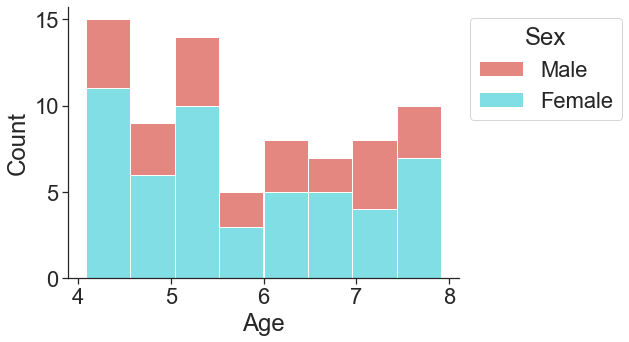

In [216]:
# Histogram of age and gender:
sns.set_theme(style="ticks",font_scale=2)
df = df_perm.drop('Age', axis = 1)
df_hist = df.rename(columns={'demo_child_gender':'Sex','Age (months)':'Age'})
df_hist['Sex'] = df_hist['Sex'].replace({1.0: 'Male', 2.0: 'Female'})
df_hist['Age'] = df_hist['Age']/12
#df_hist = df_hist[df_hist['Delay']==True]
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
g = sns.histplot(df_hist,x='Age', hue="Sex",multiple="stack",palette="hls")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
f.savefig('Figures/Supp1.png', dpi=300,bbox_inches="tight",format='png')

### Does memory improve with age?

In [217]:
cols_ = list(df_norm.columns)
d = []
dt = []
for col in cols_:
    d.append(pg.corr(df_perm['Age (months)'], df_perm[col]).to_dict('index')['pearson'])
    dt.append(pg.ttest(df_perm[df_perm['demo_child_gender'] == 1][col],
              df[df['demo_child_gender'] == 2][col]).to_dict('index')['T-test'])
corrdf = pd.DataFrame(d)
ttestdf = pd.DataFrame(dt)
corrdf.index = cols_
ttestdf.index = cols_
for k,v in {'PS/PC':['Relational\nBinding','Holistic\nRecollection',
            'Mnemonic\ndiscrimination\n(Target)'],
            #'Mnemonic\ndiscrimination\n(Foil)',
            #'Mnemonic\ndiscrimination\n(Lure)'],
           'Maus/AM':['Probed\nQuestion\nAccuracy',
            'Free\nRecall\nAccuracy','Autobiographical\nMemory']}.items():
    print('Correrelations for: '+k)
    display(corrdf.loc[v])
    display(ttestdf.loc[v])

Correrelations for: PS/PC


,n,r,CI95%,p-val,BF10,power
Relational\nBinding,76,0.445523,"[0.24, 0.61]",0.000055,417.395,0.984500
Holistic\nRecollection,76,-0.072220,"[-0.29, 0.16]",0.535272,0.173,0.095085
Mnemonic\ndiscrimination\n(Target),76,0.461758,"[0.26, 0.62]",0.000027,814.537,0.990167


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
Relational\nBinding,-0.085062,43.333980,two-sided,0.932604,"[-0.14, 0.13]",0.021581,0.251,0.050873
Holistic\nRecollection,0.304046,42.601059,two-sided,0.762573,"[-0.02, 0.03]",0.077673,0.26,0.061372
Mnemonic\ndiscrimination\n(Target),-0.839672,41.317190,two-sided,0.405925,"[-0.19, 0.08]",0.217224,0.338,0.141951


Correrelations for: Maus/AM


,n,r,CI95%,p-val,BF10,power
Probed\nQuestion\nAccuracy,76,0.504507,"[0.31, 0.66]",3.369420e-06,5690.491,0.997536
Free\nRecall\nAccuracy,76,0.678805,"[0.54, 0.78]",1.596270e-11,6.674e+08,1.000000
Autobiographical\nMemory,76,0.306106,"[0.09, 0.5]",7.161896e-03,4.975,0.775675


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
Probed\nQuestion\nAccuracy,-0.387103,40.231667,two-sided,0.700720,"[-0.22, 0.15]",0.101269,0.267,0.069415
Free\nRecall\nAccuracy,-0.560617,65.643257,two-sided,0.576967,"[-1.3, 0.73]",0.120873,0.286,0.077778
Autobiographical\nMemory,-2.701288,73.149612,two-sided,0.008579,"[-7.03, -1.06]",0.517538,5.205,0.552635


### Does memory improve with age (eliminating delay outliers)?

In [218]:
dftemp = df_perm[df_perm['Delay']<19]
cols_ = list(df_norm.columns)
d = []
dt = []
for col in cols_:
    d.append(pg.corr(dftemp['Age (months)'], dftemp[col]).to_dict('index')['pearson'])
    dt.append(pg.ttest(dftemp[dftemp['demo_child_gender'] == 1][col],
              dftemp[dftemp['demo_child_gender'] == 2][col]).to_dict('index')['T-test'])
corrdf = pd.DataFrame(d)
ttestdf = pd.DataFrame(dt)
corrdf.index = cols_
ttestdf.index = cols_
for k,v in {'PS/PC':['Relational\nBinding','Holistic\nRecollection',
            'Mnemonic\ndiscrimination\n(Target)'],
            #'Mnemonic\ndiscrimination\n(Foil)',
            #'Mnemonic\ndiscrimination\n(Lure)'],
           'Maus/AM':['Probed\nQuestion\nAccuracy',
            'Free\nRecall\nAccuracy','Autobiographical\nMemory']}.items():
    print('Correrelations for: '+k)
    display(corrdf.loc[v])
    display(ttestdf.loc[v])
N = 76
d = []
dftemp = df_hist
for col in cols_:
    coltmp = col.replace('\n','').replace('(Target)','')
    dftemp = dftemp.rename(columns={col:coltmp})
    result = sm2.ols(formula=coltmp+'~Age + Delay',data=dftemp).fit()
    for v in ['Delay','Age']:
        t = result.tvalues[v]
        r = t / np.sqrt((N - 2) + np.square(t))
        d.append({'Column':coltmp,
                 'Regressor':v,
                 'R-value':r,
                 'P-value':result.pvalues[v]})
df_delayageregression = pd.DataFrame(d)
display(df_delayageregression)

Correrelations for: PS/PC


,n,r,CI95%,p-val,BF10,power
Relational\nBinding,74,0.421898,"[0.21, 0.59]",0.000181,139.972,0.968152
Holistic\nRecollection,74,-0.055763,"[-0.28, 0.17]",0.637003,0.162,0.075784
Mnemonic\ndiscrimination\n(Target),74,0.440082,"[0.24, 0.61]",0.000087,274.856,0.979501


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
Relational\nBinding,-0.215790,38.843506,two-sided,0.830281,"[-0.15, 0.12]",0.056358,0.262,0.055634
Holistic\nRecollection,0.403260,36.921403,two-sided,0.689083,"[-0.02, 0.03]",0.107792,0.275,0.070784
Mnemonic\ndiscrimination\n(Target),-0.845835,37.378491,two-sided,0.403027,"[-0.19, 0.08]",0.224804,0.347,0.143012


Correrelations for: Maus/AM


,n,r,CI95%,p-val,BF10,power
Probed\nQuestion\nAccuracy,74,0.493205,"[0.3, 0.65]",8.022487e-06,2540.996,0.995593
Free\nRecall\nAccuracy,74,0.682992,"[0.54, 0.79]",2.033991e-11,5.296e+08,1.000000
Autobiographical\nMemory,74,0.329886,"[0.11, 0.52]",4.100980e-03,8.243,0.827641


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
Probed\nQuestion\nAccuracy,-0.417389,35.226332,two-sided,0.678927,"[-0.23, 0.15]",0.114103,0.276,0.073319
Free\nRecall\nAccuracy,-0.691951,58.687031,two-sided,0.491697,"[-1.41, 0.69]",0.152775,0.314,0.092180
Autobiographical\nMemory,-2.938796,71.523360,two-sided,0.004433,"[-7.36, -1.41]",0.557276,8.917,0.590621


,Column,Regressor,R-value,P-value
0,RelationalBinding,Delay,-0.301002,8.260945e-03
1,RelationalBinding,Age,0.454206,3.820276e-05
2,Mnemonicdiscrimination,Delay,-0.356258,1.593504e-03
3,Mnemonicdiscrimination,Age,0.477352,1.322721e-05
4,ProbedQuestionAccuracy,Delay,-0.172832,1.354937e-01
5,ProbedQuestionAccuracy,Age,0.504523,3.439978e-06
6,FreeRecallAccuracy,Delay,-0.068958,5.539409e-01
7,FreeRecallAccuracy,Age,0.676310,2.188562e-11
8,AutobiographicalMemory,Delay,-0.106515,3.598164e-01
9,AutobiographicalMemory,Age,0.303196,7.781457e-03


### How does variation in PSPC task impact performance?

In [219]:
dftemp = df_hist
d = []
for col in ['Mnemonic\ndiscrimination\n(Target)','Relational\nBinding',
            'Mnemonic\ndiscrimination\n(Lure)', 'Mnemonic\ndiscrimination\n(Foil)',
            'Holistic\nRecollection']:
    coltmp = col.replace('\n','').replace('(','').replace(')','')
    dftemp = dftemp.rename(columns={col:coltmp})
    result = sm2.ols(formula=coltmp+'~Age + DelayPSPC',data=dftemp).fit()
    for v in ['DelayPSPC','Age']:
        t = result.tvalues[v]
        r = t / np.sqrt((N - 2) + np.square(t))
        d.append({'Column':coltmp,
                 'Regressor':v,
                 'R-value':r,
                 'P-value':result.pvalues[v]})
df_pspcdelay = pd.DataFrame(d)
display(df_pspcdelay)

,Column,Regressor,R-value,P-value
0,MnemonicdiscriminationTarget,DelayPSPC,-0.684590,1.000218e-11
1,MnemonicdiscriminationTarget,Age,0.459454,3.023686e-05
2,RelationalBinding,DelayPSPC,-0.717408,3.429365e-13
3,RelationalBinding,Age,0.447355,5.154594e-05
4,MnemonicdiscriminationLure,DelayPSPC,0.584677,3.050743e-08
5,MnemonicdiscriminationLure,Age,-0.351028,1.886349e-03
6,MnemonicdiscriminationFoil,DelayPSPC,0.642432,4.216641e-10
7,MnemonicdiscriminationFoil,Age,-0.427710,1.175675e-04
8,HolisticRecollection,DelayPSPC,0.017664,8.796246e-01
9,HolisticRecollection,Age,-0.067026,5.651228e-01


### Delay IS significantly related to Mnemonic Discrimination and Holistic Recollection performance (even after controlling for the effect of age)!
### Therefore, let's regress-out delay in this task from future analyses:

In [220]:
def regressout(df,col,col_list):
    c_regression = LinearRegression().fit(df[col_list],df[col])
    new_col = df[col] - c_regression.predict(df[col_list])
    return new_col
df_controlvars2['DelayPSPC'] = df_hist['DelayPSPC']
df_controlvars2['Delay'] = df_hist['Delay']
# regress out age and IQ and Delay from PSPC task
control_vars = ['Age (months)','IQ']
PSPCcols = ['Relational\nBinding','Mnemonic\ndiscrimination\n(Target)']
Mauscols = ['Probed\nQuestion\nAccuracy','Free\nRecall\nAccuracy']
for c in df_controlvars2.columns:
    if c in PSPCcols:
        df_controlvars2[c] = regressout(df_controlvars2,c,control_vars+['DelayPSPC'])
    elif c not in control_vars:
        df_controlvars2[c] = regressout(df_controlvars2,c,control_vars)
df_controlvars2 = df_controlvars2.drop(control_vars+['DelayPSPC','Delay'], axis=1)
df_controlvars2.to_csv('csvs/residualdf.csv',index=False)

In [221]:
df_controlvars1['DelayPSPC'] = df_hist['DelayPSPC']
df_controlvars1_v2['DelayPSPC'] = df_hist['DelayPSPC']
df_controlvars1['Delay'] = df_hist['Delay']
df_controlvars1_v2['Delay'] = df_hist['Delay']
# regress out Delay from PSPC task
PSPCcols = ['Relational\nBinding','Mnemonic\ndiscrimination\n(Target)',
            'Mnemonic\ndiscrimination\n(Lure)', 'Mnemonic\ndiscrimination\n(Foil)']
for df in [df_controlvars1,df_controlvars1_v2,df_perm]:
    for c in PSPCcols:
        c_regression = LinearRegression().fit(df['DelayPSPC'].to_numpy().reshape(-1, 1),
                                              df[c])
        c_residuals = df[c] - c_regression.predict(df['DelayPSPC'].to_numpy().reshape(-1, 1))
        df[c] = c_residuals
df_controlvars1 = df_controlvars1.drop(['DelayPSPC','Delay'], axis=1)
df_controlvars1_v2 = df_controlvars1_v2.drop(['DelayPSPC','Delay'], axis=1)

### Descriptive statistics with delay regressed out of PSPC measure:

In [222]:
df_descriptives = descriptives(df_perm)
display(df_descriptives)

,Column,Mean,Median,Standard Deviaion,Minimum,Maximum,Range,Skew,Kurtosis
0,Probed\nQuestion\nAccuracy,1.697365e+00,1.772727,0.345333,0.363636,2.000000,1.636364,-1.707687,3.344091
1,Free\nRecall\nAccuracy,5.117544e+00,4.833333,2.341380,0.666667,11.666667,11.000000,0.313766,-0.321586
2,Autobiographical\nMemory,1.245395e+01,10.500000,7.994447,1.500000,43.750000,42.250000,1.772624,4.012110
3,Mnemonic\ndiscrimination\n(Target),7.815386e-17,0.040629,0.181708,-0.485065,0.362620,0.847685,-0.404342,0.060413
4,Mnemonic\ndiscrimination\n(Lure),2.921640e-18,0.002100,0.069217,-0.106016,0.205804,0.311819,0.738419,0.231896
5,Mnemonic\ndiscrimination\n(Foil),-5.843279e-18,-0.035553,0.138325,-0.317921,0.353336,0.671257,0.365845,0.037711
6,Holistic\nRecollection,3.887806e-02,0.028807,0.052787,-0.080247,0.203704,0.283951,0.919035,1.039900
7,Relational\nBinding,1.606902e-17,-0.002470,0.177253,-0.548766,0.506720,1.055487,-0.191651,0.357882


### Relationship between memory and IQ:

In [128]:
cols_ = list(df_norm.columns)
d = []
for col in cols_:
    d.append(pg.corr(df['IQ'], df[col]).to_dict('index')['pearson'])
corrdf = pd.DataFrame(d)
corrdf.index = cols_
for k,v in {'PS/PC':['Relational\nBinding','Holistic\nRecollection',
            'Mnemonic\ndiscrimination\n(Target)'],
            #'Mnemonic\ndiscrimination\n(Foil)',
            #'Mnemonic\ndiscrimination\n(Lure)'],
           'Maus/AM':['Probed\nQuestion\nAccuracy',
            'Free\nRecall\nAccuracy','Autobiographical\nMemory']}.items():
    print('Correrelations for: '+k)
    display(corrdf.loc[v])

Correrelations for: PS/PC


,n,r,CI95%,p-val,BF10,power
Relational\nBinding,76,0.143042,"[-0.09, 0.36]",0.217689,0.302,0.235522
Holistic\nRecollection,76,-0.082723,"[-0.3, 0.15]",0.477439,0.184,0.109637
Mnemonic\ndiscrimination\n(Target),76,0.080378,"[-0.15, 0.3]",0.490055,0.181,0.106201


Correrelations for: Maus/AM


,n,r,CI95%,p-val,BF10,power
Probed\nQuestion\nAccuracy,76,0.256622,"[0.03, 0.46]",0.025239,1.671,0.616233
Free\nRecall\nAccuracy,76,0.187393,"[-0.04, 0.4]",0.105023,0.52,0.370544
Autobiographical\nMemory,76,0.129746,"[-0.1, 0.35]",0.263959,0.264,0.201608


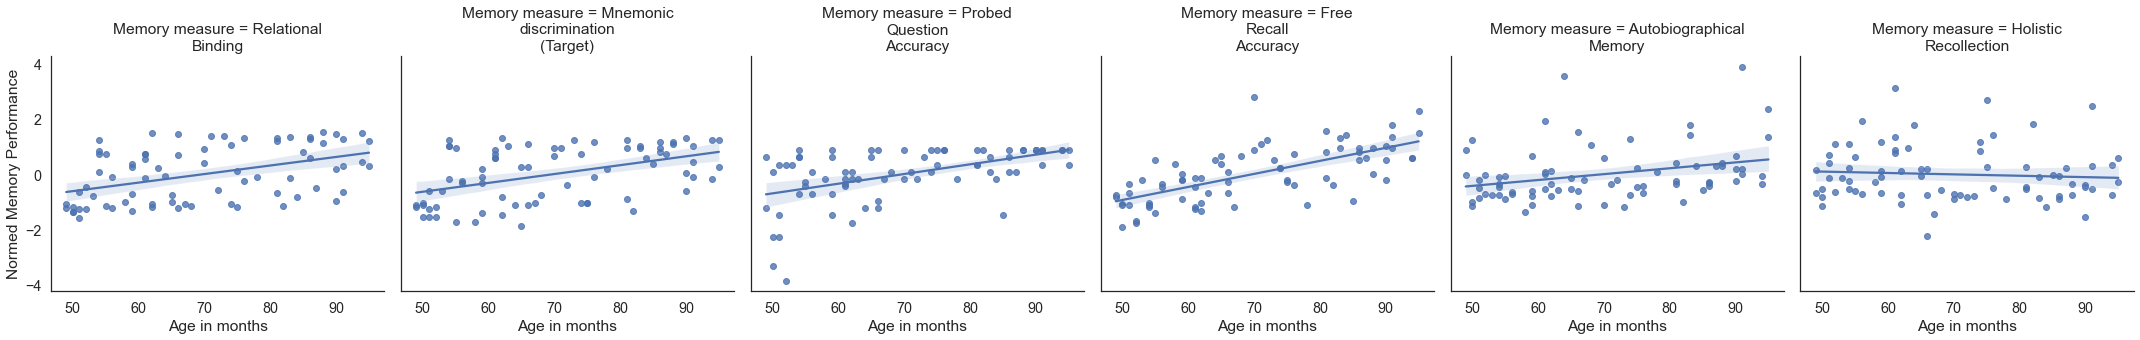

In [129]:
figdflist = []
for row in range(len(df)):
    for col in df_norm.columns:
        figdflist.append({'s':row, 'Normed Memory Performance':df_norm.iloc[row][col],
                         'Memory measure':col,'Age in months':df_hist.iloc[row]['Age']*12})
figdf = pd.DataFrame(figdflist)
sns.set_theme(style="white",font_scale=1.3)
g = sns.lmplot(
    data=figdf,
    x='Age in months', y='Normed Memory Performance', col="Memory measure")

In [130]:
# Compute the correlation matrix
corr_matrix = df_norm.corr()
# threshold variables above 0.7 correlation:
threshlist = []
threshold = 0.8
d = []
for row in corr_matrix.index.values.tolist():
    cols = corr_matrix.columns[(corr_matrix.loc[row].gt(threshold))|(corr_matrix.loc[row].lt(-1*threshold))].tolist()
    for col in cols:
        if row != col:
            threshlist.append([row,col])
            d.append({'row':row,'col':col,'r':corr_matrix.loc[row,col]})
pd.DataFrame(d)

,row,col,r
0,Relational\nBinding,Mnemonic\ndiscrimination\n(Target),0.877319
1,Mnemonic\ndiscrimination\n(Target),Relational\nBinding,0.877319


In [131]:
# Eliminate 
#df_norm = df_norm.drop(  
#['Mnemonic\ndiscrimination\n(Lure)','Mnemonic\ndiscrimination\n(Foil)'], axis=1)

In [132]:
# Find any weakly correlated variables:
corr_matrix = df_norm.corr()
threshlist = []
threshold = 0.2
for row in corr_matrix.index.values.tolist():
    tmp = corr_matrix.drop(index=[row])
    if (tmp[row].max()<threshold) & (tmp[row].min()>(-1*threshold)):
        threshlist.append(row)
        print(row)
# drop Dependency
#df_norm = df_norm.drop(['Dependency'], axis=1)

Holistic
Recollection


In [133]:
def plot_xcorr(df,figname,control,rot):
    sns.set_theme(style="white",font_scale=1.3)
    if control == 1:
        # regress out age and IQ
        control_vars = ['Age (months)','IQ']
        for c in df.columns:
            if c not in control_vars:
                c_regression = LinearRegression().fit(df[control_vars], df[c])
                c_residuals = df[c] - c_regression.predict(df[control_vars])
                df[c] = c_residuals
        df = df.drop(control_vars, axis=1)
    corr_matrix = df.corr()
    # Adding pvals from:
    # https://stackoverflow.com/questions/69900363/colour-statistically-non-significant-values-in-seaborn-heatmap-with-a-different
    pvals = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*df.corr().shape)
    # set the significance threshold
    psig = 0.05
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    g = sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1,center=0,
                    square=True, linewidths=.5, 
                    cbar_kws={"shrink": .75,'label': 'Correlation',
                              'ticks':[-1,0,1]},annot=True)
    # add another heatmap with colouring the non-significant cells
    g = sns.heatmap(corr_matrix[pvals>=psig], mask=mask, 
                    cmap=sns.color_palette("Greys", n_colors=1, desat=1), 
                    cbar=False,square=True, linewidths=.5, annot=True)
                    #yticklabels=yticks,xticklabels=xticks)
    if rot == 1:
        g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 12)
        plt.xticks(rotation = 60, ha="right", rotation_mode='anchor')
    else:
        g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 13)
        plt.xticks(rotation=0)
    # Remove the first y-axis label
    ax.set_yticklabels([' ']+ax.get_yticklabels()[1:])
    ax.set_xticklabels(ax.get_xticklabels()[:-1]+[' '])
    
    # add a label for the colour
    # https://stackoverflow.com/questions/44098362/using-mpatches-patch-for-a-custom-legend
    colors = [sns.color_palette("Greys", n_colors=1, desat=1)[0]]
    texts = [f"n.s. (p>{psig})"]
    patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
    plt.legend(handles=patches, bbox_to_anchor=(.85, 0.85), loc='center',prop={'size': 15})
    plt.savefig('Figures/'+figname+'.png', dpi=600,bbox_inches="tight",format='png')
    return df

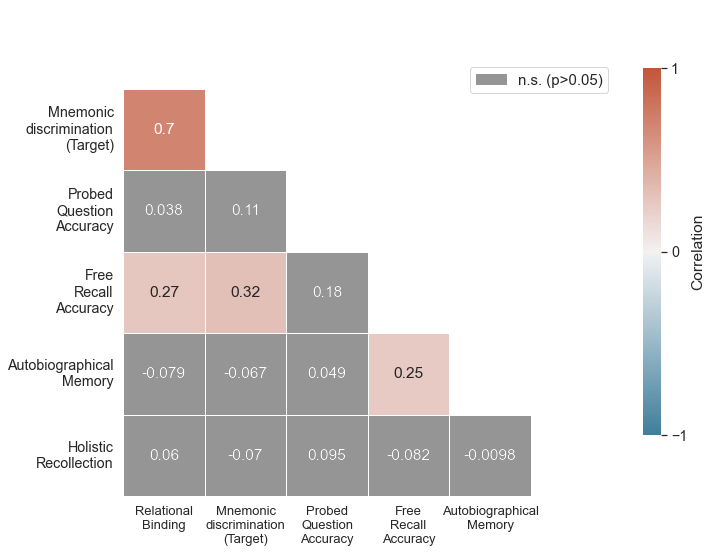

In [134]:
tmp = plot_xcorr(df_controlvars2,'Figure3',0,0)

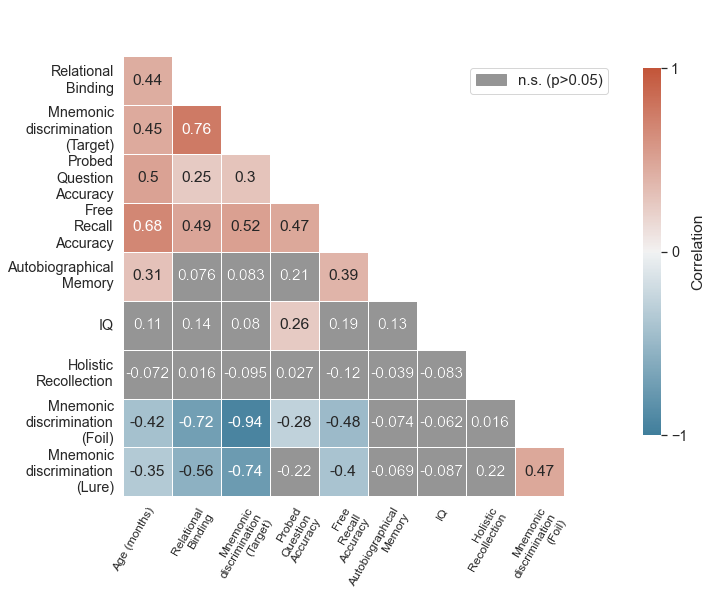

In [135]:
tmp=plot_xcorr(df_controlvars1,'Figure2',0,1)

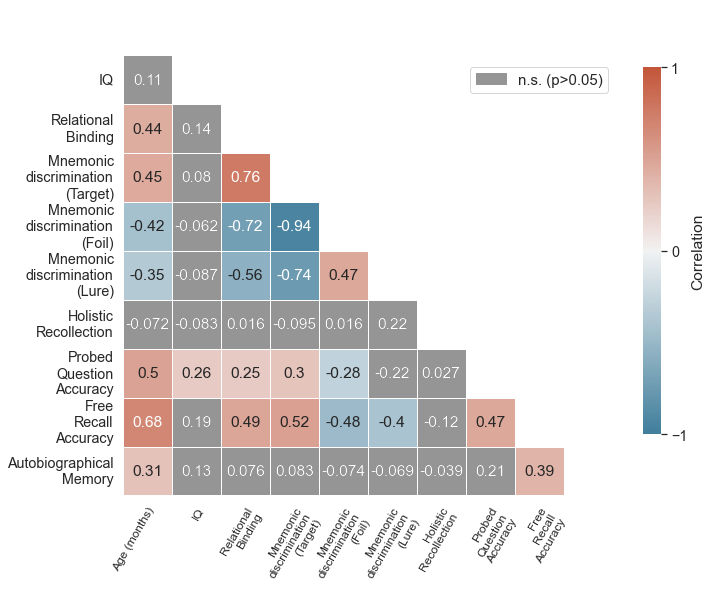

In [136]:
# Graph of Figure 2 in different order:
tmp=plot_xcorr(df_controlvars1_v2,'Figure2_reorder',0,1)

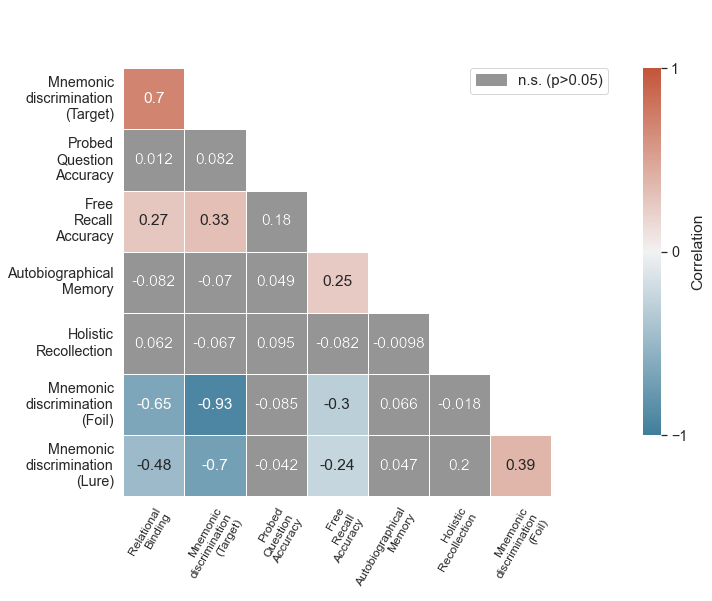

In [137]:
# Graph including other mnemonic discrimination measures (for lure and foil):

tmp=plot_xcorr(df_controlvars1,'tmp',1,1)

In [138]:
from scipy import stats
for col in df_norm.columns:
    res = stats.normaltest(df_norm[col])
    #print(col)
    #print(res)

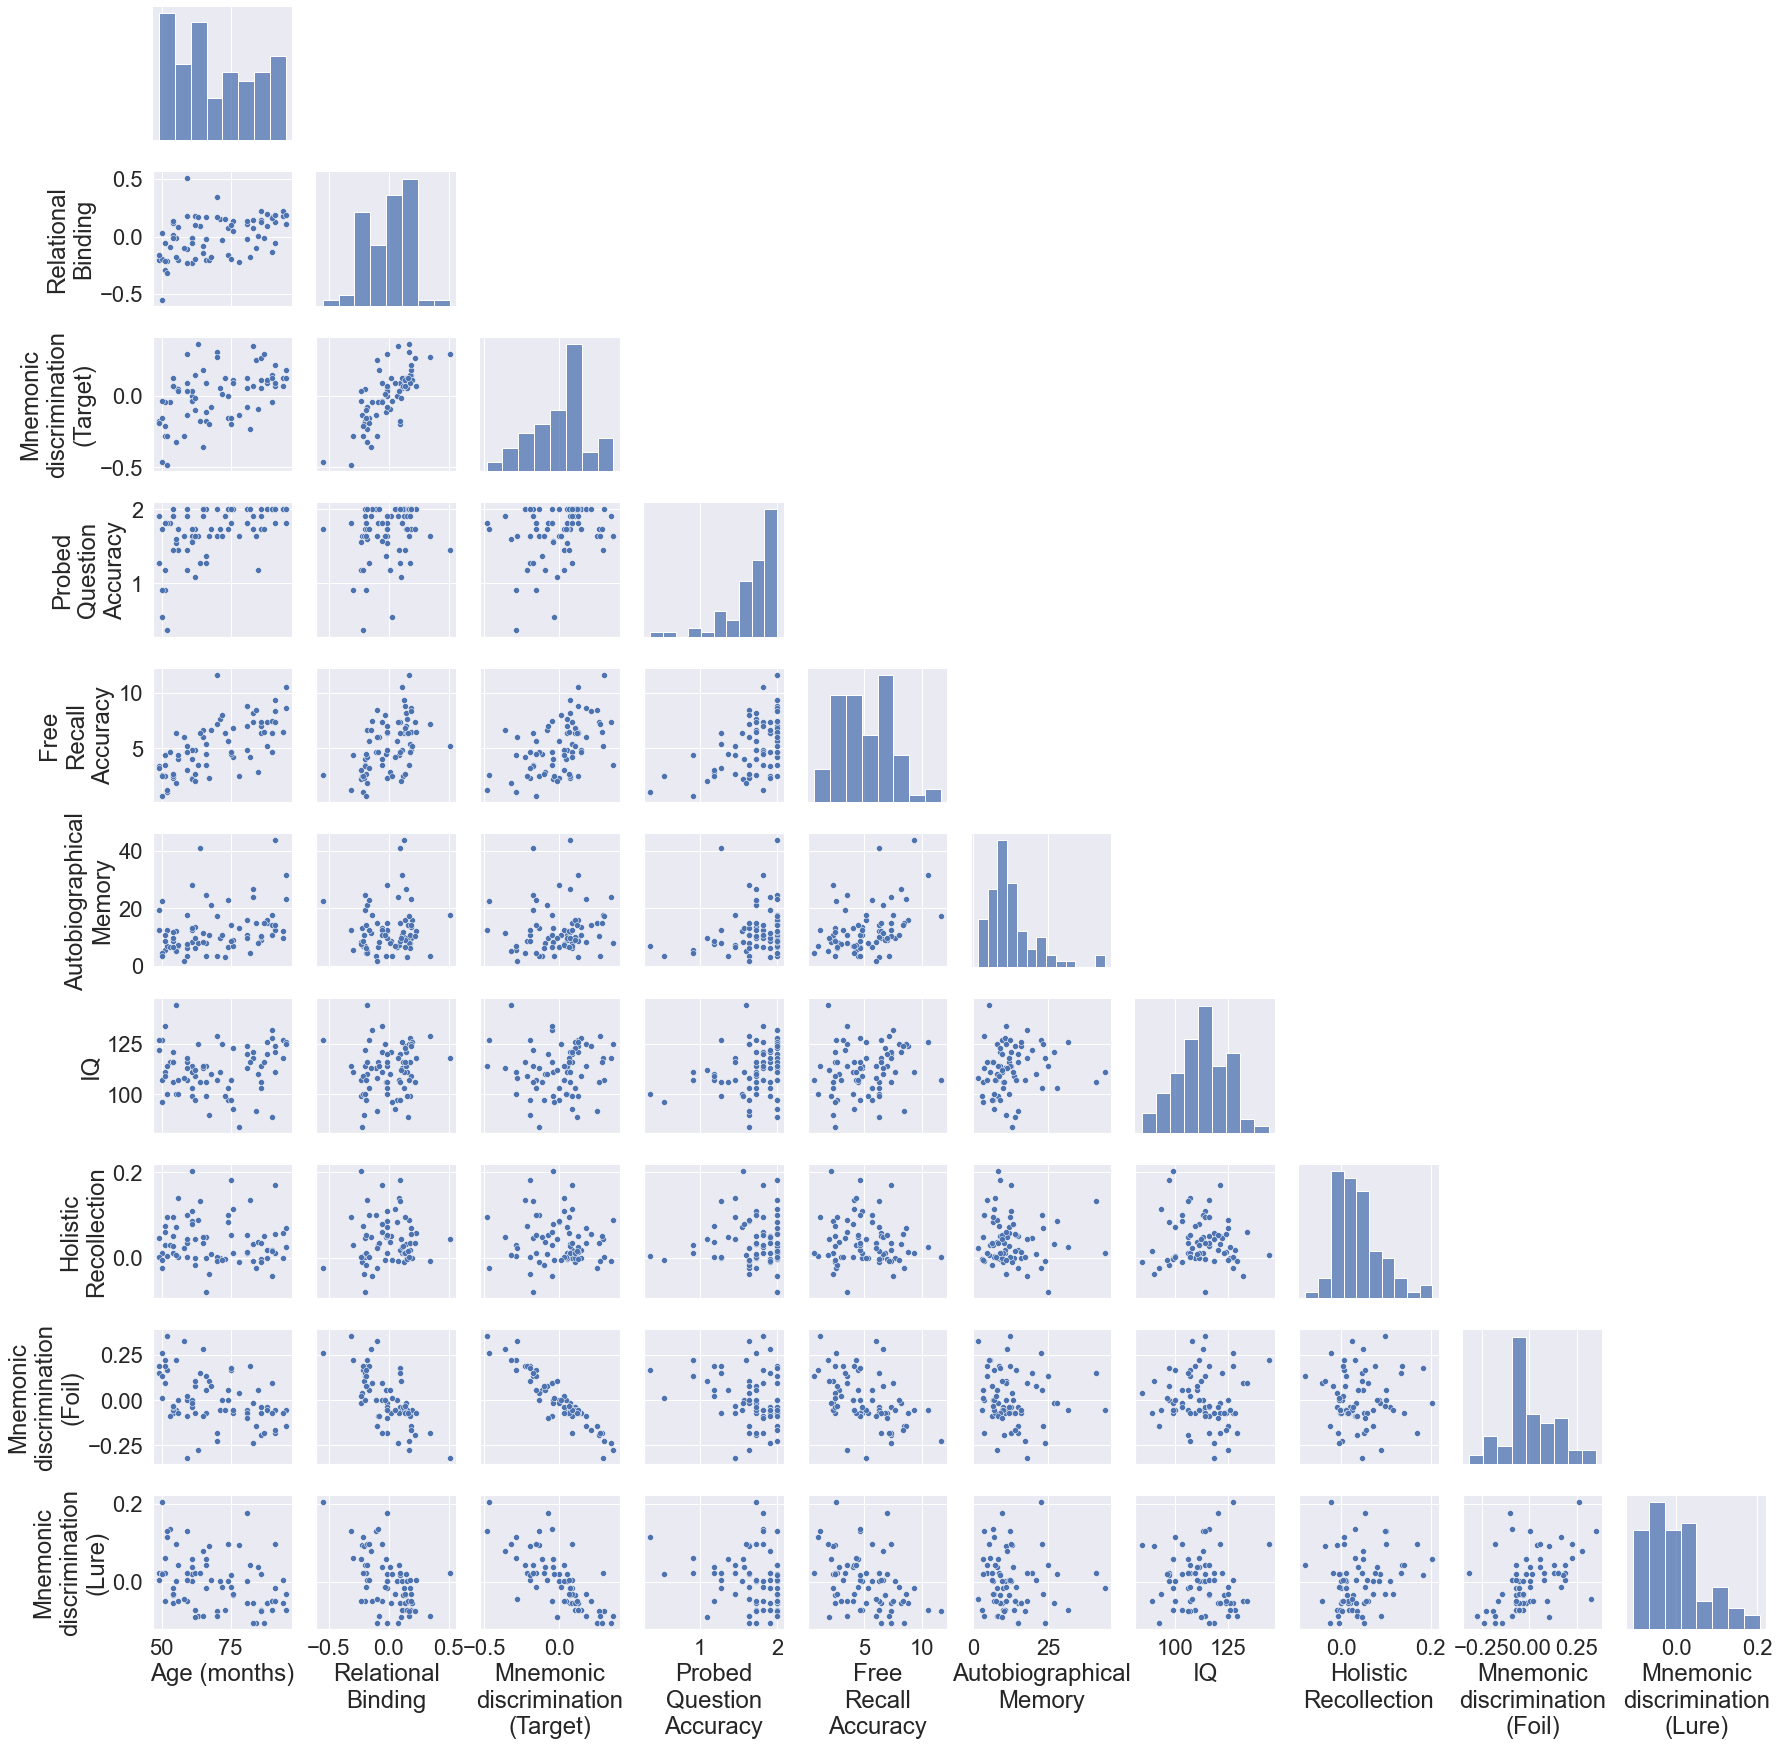

In [143]:
dftmp = df_perm[df_controlvars1.columns]
sns.set(font_scale=2)
g = sns.PairGrid(dftmp, diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)
g.figure.savefig('Figures/SuppFig4.png', dpi=100,bbox_inches="tight",format='png')

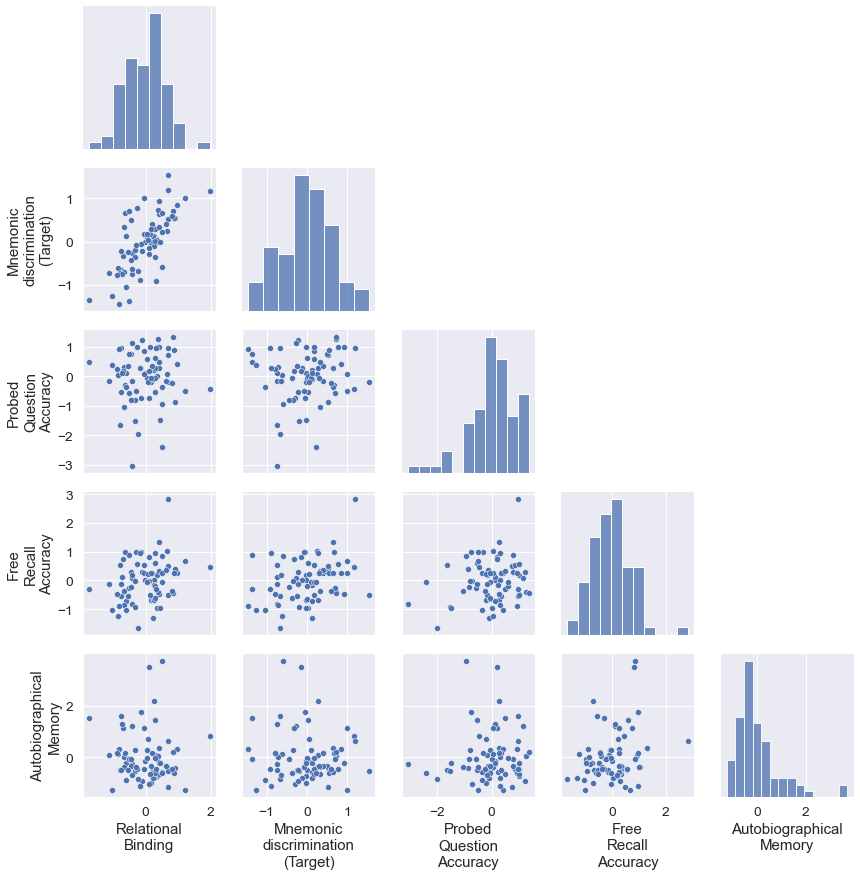

In [205]:
dftmp = df_controlvars2.drop(['Holistic\nRecollection'], axis=1)
sns.set(font_scale=1.25)
g = sns.PairGrid(dftmp, diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)
g.figure.savefig('Figures/SuppFig5.png', dpi=100,bbox_inches="tight",format='png')

In [210]:
def find_outliers_IQR_col(df,cols):
    outliers = df
    nonoutliers = df
    for c in cols:
        q1=df[c].quantile(0.25)
        q3=df[c].quantile(0.75)
        IQR=q3-q1
        outliers[c] = df[c][((df[c]<(q1-1.5*IQR)) | (df[c]>(q3+1.5*IQR)))]
        nonoutliers[c] = df[c][((df[c]>(q1-1.5*IQR)) & (df[c]<(q3+1.5*IQR)))]
    return outliers,nonoutliers
def find_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    nonoutliers = df[((df>(q1-1.5*IQR)) & (df<(q3+1.5*IQR)))]
    return outliers,nonoutliers
#[outliers_,nanoutlierdf_] = find_outliers_IQR_col(dftmp,['Probed\nQuestion\nAccuracy','Autobiographical\nMemory'])
dftmp = df_controlvars2.drop(['Holistic\nRecollection'], axis=1)
[outliers,nanoutlierdf] = find_outliers_IQR(dftmp)
df_cleaned = nanoutlierdf.dropna()
display(df_cleaned)
df_cleaned.to_csv('csvs/residualdf_noout.csv',index=False)

,Relational\nBinding,Mnemonic\ndiscrimination\n(Target),Probed\nQuestion\nAccuracy,Free\nRecall\nAccuracy,Autobiographical\nMemory
0,0.337348,-0.017927,1.001621,0.188188,-0.704085
1,0.405947,0.648621,0.271851,1.325497,0.350171
2,0.169291,-0.028781,-0.203498,-0.688338,-0.996063
4,0.966307,0.836451,0.403150,0.268649,0.317010
5,0.240127,0.008806,-0.044166,-0.654648,-0.483995
...,...,...,...,...,...
70,0.080501,0.046109,-0.201711,0.210780,0.720252
71,-0.292286,-0.075748,-0.480386,0.994804,-0.369093
72,0.173053,0.290803,-0.049320,0.264388,-0.345829
73,-0.167980,-0.894638,0.292291,0.962904,-1.093060


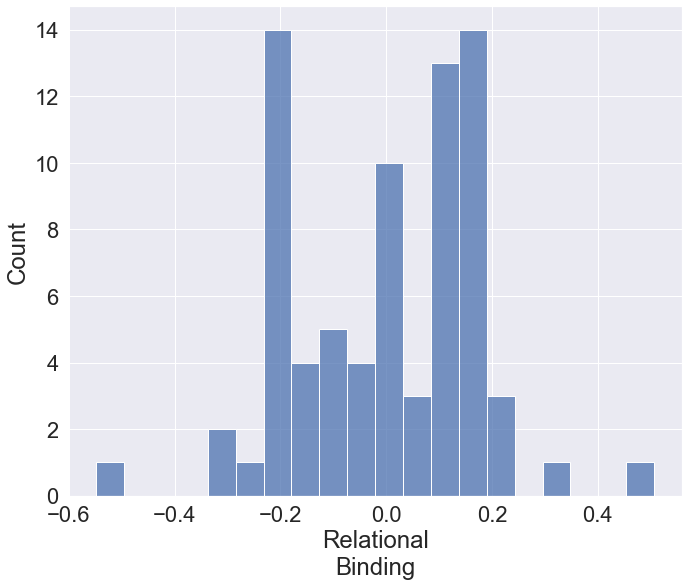

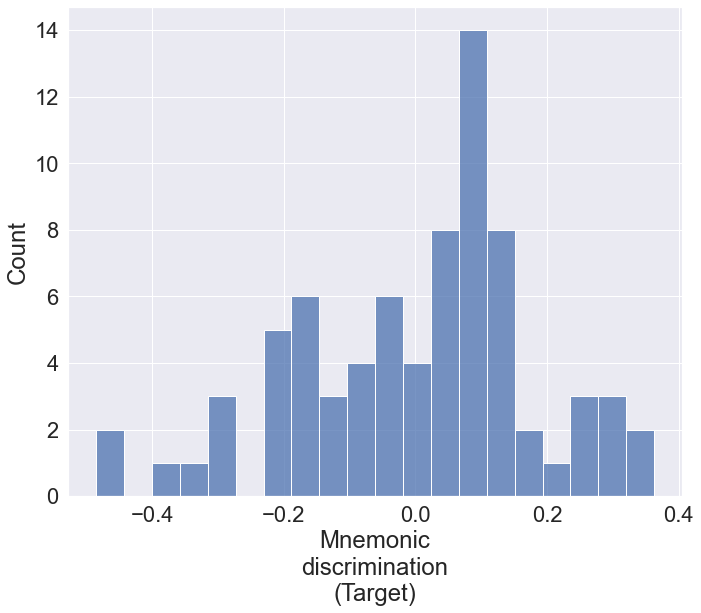

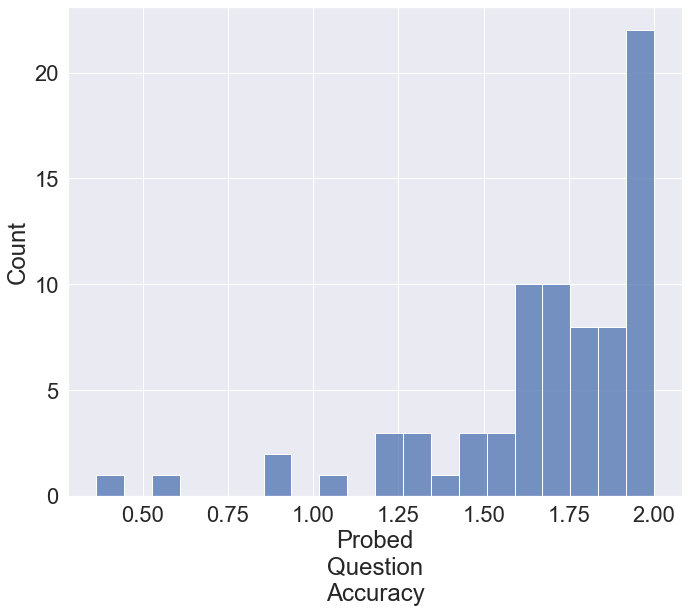

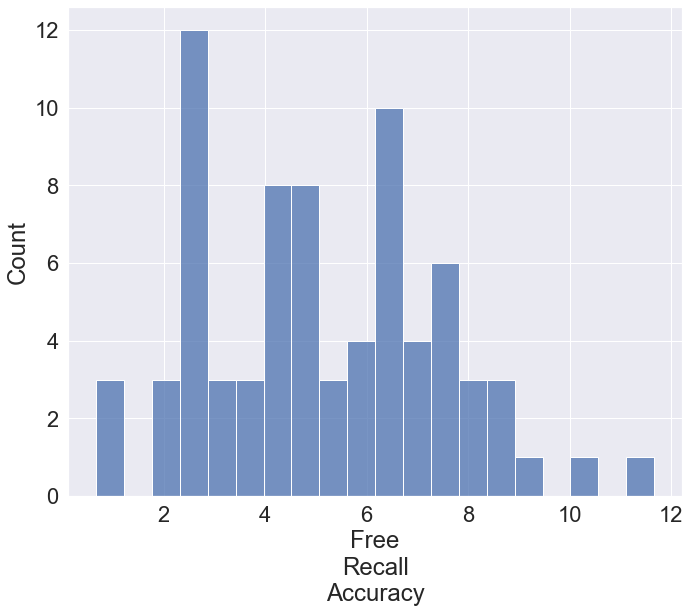

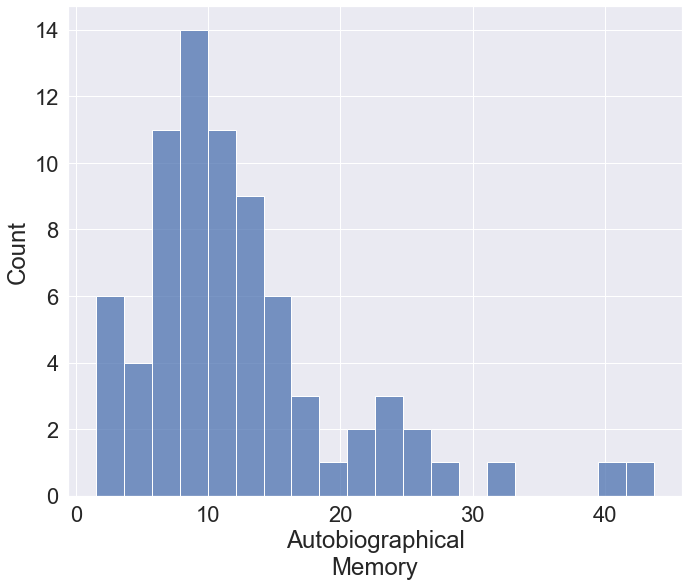

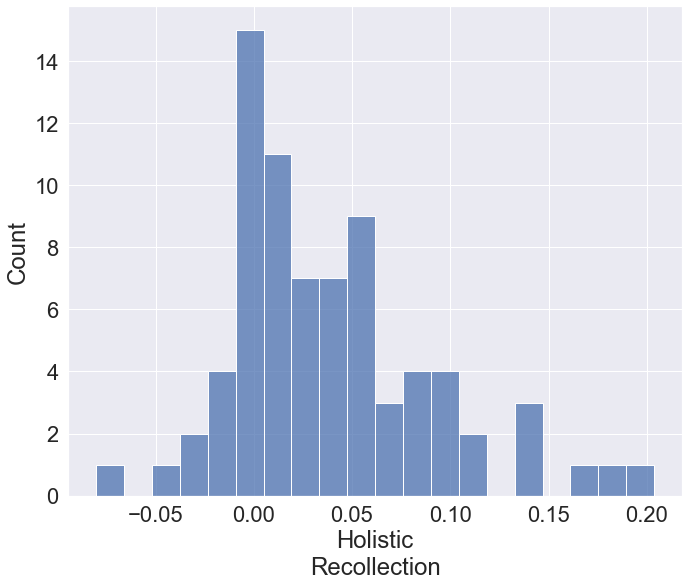

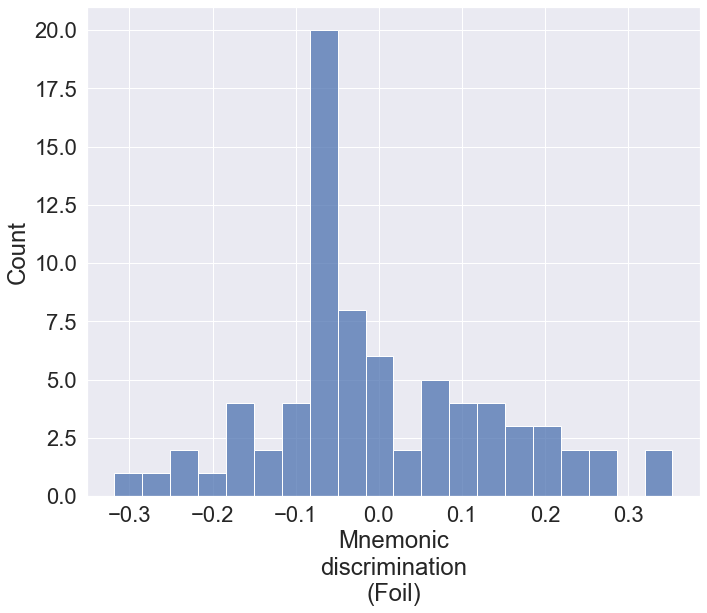

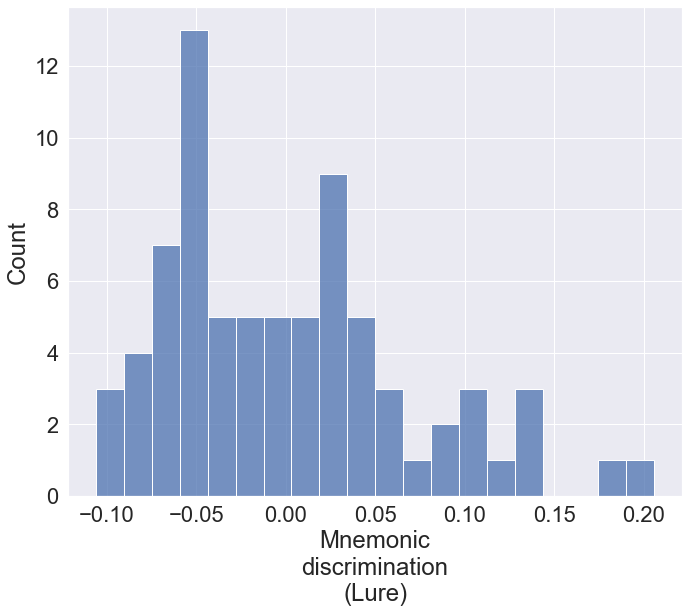

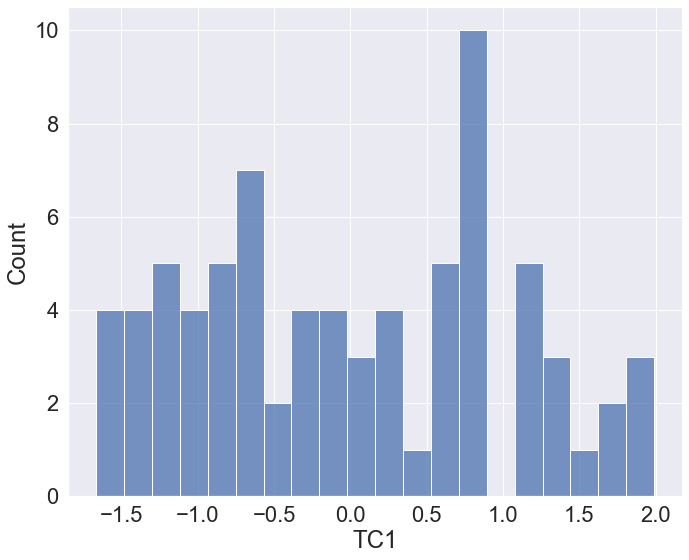

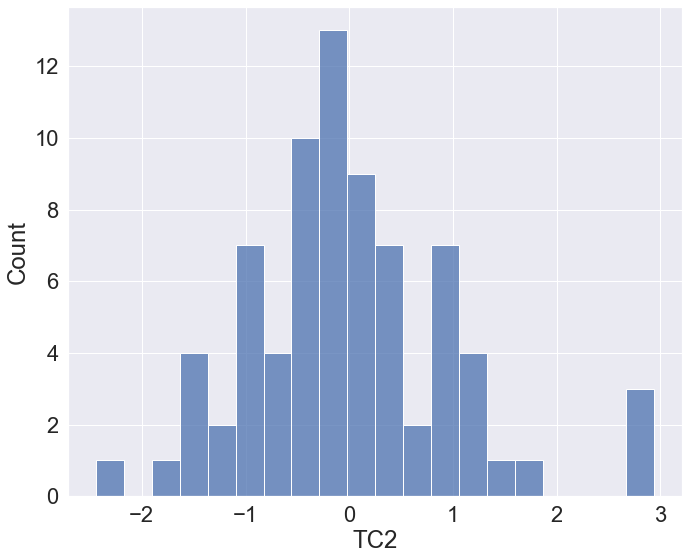

In [140]:
for col in ['Relational\nBinding','Mnemonic\ndiscrimination\n(Target)',
                   'Probed\nQuestion\nAccuracy',
                   'Free\nRecall\nAccuracy','Autobiographical\nMemory',
                   'Holistic\nRecollection',
                   'Mnemonic\ndiscrimination\n(Foil)',
                   'Mnemonic\ndiscrimination\n(Lure)']:
    f, ax = plt.subplots(figsize=(11, 9))
    g = sns.histplot(data=df, x=col, bins=20)
    plt.savefig('Figures/'+col.replace('\n',' ')+'.png', dpi=300,bbox_inches="tight",format='png')
    
scores2 = pd.read_csv("csvs/scores2.csv")
for col in ['TC1','TC2']:
    f, ax = plt.subplots(figsize=(11, 9))
    g = sns.histplot(data=scores2, x=col, bins=20)
    plt.savefig('Figures/'+col+'.png', dpi=300,bbox_inches="tight",format='png')

In [302]:
# from:
# https://stackoverflow.com/questions/62303782/is-there-a-way-to-conduct-a-parallel-analysis-in-python
def _HornParallelAnalysis(data, K=100, printEigenvalues=False):
    ################
    # Create a random matrix to match the dataset
    ################
    n, m = data.shape
    # Set the factor analysis parameters
    fa = FactorAnalyzer(n_factors=1, method='minres', rotation=None, use_smc=True)
    # Create arrays to store the values
    sumComponentEigens = np.empty(m)
    sumFactorEigens = np.empty(m)
    # Run the fit 'K' times over a random matrix
    for runNum in range(0, K):
        fa.fit(np.random.normal(size=(n, m)))
        sumComponentEigens = sumComponentEigens + fa.get_eigenvalues()[0]
        sumFactorEigens = sumFactorEigens + fa.get_eigenvalues()[1]
    # Average over the number of runs
    avgComponentEigens = sumComponentEigens / K
    avgFactorEigens = sumFactorEigens / K

    ################
    # Get the eigenvalues for the fit on supplied data
    ################
    fa.fit(data)
    dataEv = fa.get_eigenvalues()
    # Set up a scree plot
    plt.figure(figsize=(8, 6))

    ################
    ### Print results
    ################
    if printEigenvalues:
        print('Principal component eigenvalues for random matrix:\n', avgComponentEigens)
        print('Factor eigenvalues for random matrix:\n', avgFactorEigens)
        print('Principal component eigenvalues for data:\n', dataEv[0])
        print('Factor eigenvalues for data:\n', dataEv[1])
    # Find the suggested stopping points
    suggestedFactors = sum((dataEv[1] - avgFactorEigens) > 0)
    suggestedComponents = sum((dataEv[0] - avgComponentEigens) > 0)
    print('Parallel analysis suggests that the number of factors = ', suggestedFactors , ' and the number of components = ', suggestedComponents)


    ################
    ### Plot the eigenvalues against the number of variables
    ################
    # Line for eigenvalue 1
    plt.plot([0, m+1], [1, 1], 'k--', alpha=0.3)
    # For the random data - Components
    plt.plot(range(1, m+1), avgComponentEigens, 'b', label='PC - random', alpha=0.4)
    # For the Data - Components
    plt.scatter(range(1, m+1), dataEv[0], c='b', marker='o')
    plt.plot(range(1, m+1), dataEv[0], 'b', label='PC - data')
    # For the random data - Factors
    plt.plot(range(1, m+1), avgFactorEigens, 'g', label='FA - random', alpha=0.4)
    # For the Data - Factors
    plt.scatter(range(1, m+1), dataEv[1], c='g', marker='o')
    plt.plot(range(1, m+1), dataEv[1], 'g', label='FA - data')
    plt.title('Parallel Analysis Scree Plots', {'fontsize': 20})
    plt.xlabel('Factors/Components', {'fontsize': 15})
    plt.xticks(ticks=range(1, m+1), labels=range(1, m+1))
    plt.ylabel('Eigenvalue', {'fontsize': 15})
    plt.legend()
    plt.show();

In [303]:
def EFA(df,n_factors):
    # inspired by: 
    # https://www.datacamp.com/tutorial/introduction-factor-analysis
    from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
    chi_square_value,p_value=calculate_bartlett_sphericity(df)
    print('Bartlett\'s test results:')
    print(chi_square_value, p_value)
    from factor_analyzer.factor_analyzer import calculate_kmo
    kmo_all,kmo_model=calculate_kmo(df)
    print('KMO test results:')
    print(kmo_model)
    # Create factor analysis object and perform factor analysis
    fa = FactorAnalyzer()
    fa.set_params(n_factors=3, rotation=None)
    fa.fit(df)
    # Check Eigenvalues
    ev, v = fa.get_eigenvalues()
    # Create scree plot using matplotlib
    plt.scatter(range(1,df.shape[1]+1),ev)
    plt.plot(range(1,df.shape[1]+1),ev)
    plt.title('Scree Plot')
    plt.xlabel('Factors')
    plt.ylabel('Eigenvalue')
    plt.grid()
    plt.show()
    # Create factor analysis object and perform factor analysis
    fa = FactorAnalyzer()
    fa.set_params(n_factors=n_factors, rotation="varimax")
    fa.fit(df)
    var_exp = fa.get_factor_variance()
    arr = np.concatenate((fa.loadings_, 
                          fa.get_factor_variance()[1][np.newaxis],), axis=0)
    factor_df=pd.DataFrame(arr,index=list(df.columns)+['Variance Explained'])
    print(factor_df)

Bartlett's test results:
115.17711214284914 1.624191238133765e-17
KMO test results:
0.6438515794935172


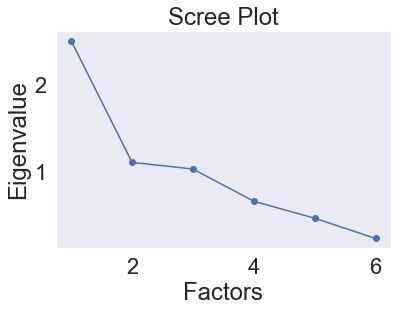

                                         0         1         2         3
Relational\nBinding               0.900449  0.163967  0.063610  0.145918
Probed\nQuestion\nAccuracy        0.280986  0.341373  0.058823  0.640610
Free\nRecall\nAccuracy            0.251139  0.873079 -0.080073  0.171675
Autobiographical\nMemory          0.036121  0.416337 -0.022138  0.096899
Holistic\nRecollection           -0.058943 -0.056904  0.726740  0.032133
Mnemonic\ndiscrimination\n(Lure) -0.788399 -0.135920  0.197173 -0.175003
Variance Explained                0.263197  0.183456  0.096906  0.083699
Parallel analysis suggests that the number of factors =  3  and the number of components =  1


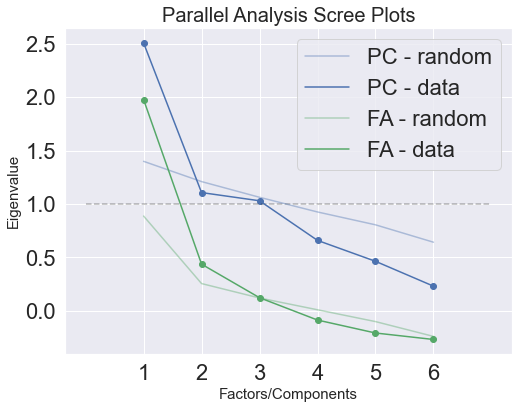

In [304]:
EFA(df_norm,4)
_HornParallelAnalysis(df_norm, K=100, printEigenvalues=False)

EFA w/o KBIT:
Bartlett's test results:
79.2264271651731 7.116855420426194e-13
KMO test results:
0.6716657369030437


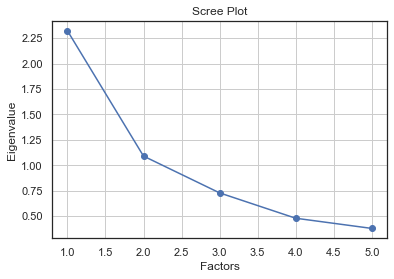

                           0         1
MausQs              0.332000  0.455551
MausFR              0.236945  0.865568
AM                  0.043630  0.439732
PCAccuracy          0.982301  0.176491
PSLocLure          -0.568999 -0.154599
Variance Explained  0.291389  0.241030
Parallel analysis suggests that the number of factors =  2  and the number of components =  1


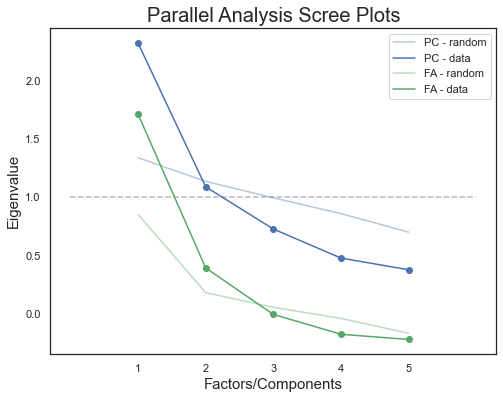

In [49]:
df_nokbit = df_norm.drop(['KBit_Score','Raw KBIT'], axis=1)
print('EFA w/o KBIT:')
EFA(df_nokbit,2)
_HornParallelAnalysis(df_nokbit, K=100, printEigenvalues=False)

In [20]:
# from:
# https://stackoverflow.com/questions/54347275/confirmatory-factor-analysis-in-python
from factor_analyzer import (ConfirmatoryFactorAnalyzer, ModelSpecificationParser)    
model_dict = {"F1": ['PCAccuracy','PSLocLure'], "F2": ['MausQs', 'MausFR','AM']}
model_spec = ModelSpecificationParser.parse_model_specification_from_dict(df_nokbit, model_dict)
cfa = ConfirmatoryFactorAnalyzer(model_spec, disp=True) 
cfa.fit(df_nokbit.values) 
cfa.loadings_ 

array([[ 1.14445425,  0.        ],
       [ 0.98356122,  0.        ],
       [ 0.        , -1.56843807],
       [ 0.        ,  4.93987078],
       [ 0.        , -2.61116823]])